([<matplotlib.axis.XTick at 0x11475b2e8>,
 <a list of 3 Text xticklabel objects>)

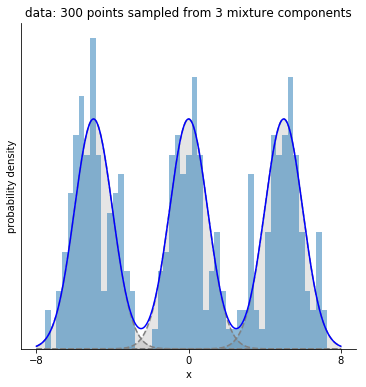

In [1]:
# RJMC for GMMs:
import matplotlib.pyplot as plt
%matplotlib inline

from autograd import numpy as np
np.random.seed(0)
from scipy.stats import norm
from scipy.stats import dirichlet
from scipy.special import logsumexp

def gaussian_mixture_log_likelihood(X, means, stdevs, weights):
    component_log_pdfs = np.array([norm.logpdf(X, loc=mean, scale=stdev) + np.log(weight) for ((mean, stdev), weight) in zip(zip(means, stdevs), weights)])
    return np.sum(logsumexp(component_log_pdfs, 0))

from scipy.stats import norm, invgamma
from scipy.special import logsumexp

def unpack(theta):
    assert(len(theta) % 3 == 0)
    n = int(len(theta) / 3)
    means, stdevs, weights = np.array(theta[:n]), np.array(theta[n:2*n]), np.array(theta[2*n:])
    return means, stdevs, weights

def log_prior(theta):
    means, stdevs, weights = unpack(theta)
    log_prior_on_means = np.sum(norm.logpdf(means, scale=20))
    log_prior_on_variances = np.sum(invgamma.logpdf((stdevs**2), 1.0))
    #log_prior_on_weights = dirichlet.logpdf(weights, np.ones(len(weights)))
    #log_prior_on_weights = np.sum(np.log(weights))
    log_prior_on_weights = 0 # removing the prior on weights to see if this is the culprit...
    return log_prior_on_means + log_prior_on_variances + log_prior_on_weights

def flat_log_p(theta):
    means, stdevs, weights = unpack(theta)
    if np.min(stdevs) <= 0.001: return - np.inf
    log_likelihood = gaussian_mixture_log_likelihood(X=data, means=means,
                                           stdevs=stdevs,
                                           weights=weights)
    
    return log_likelihood + log_prior(theta)

#n_components = 10
#true_means = np.random.rand(n_components) * 10 - 5
#true_stdevs = np.random.rand(n_components) * 0.2
#true_weights = np.random.rand(n_components)**2
#true_weights /= np.sum(true_weights)

n_data = 300
data = np.zeros(n_data)
#for i in range(n_data):
#    component = np.random.choice(np.arange(n_components), p=true_weights)
#    #component = np.random.randint(n_components)
#    data[i] = norm.rvs(loc=true_means[component], scale=true_stdevs[component])

#n_components = 10
#true_means = np.linspace(-5,5,n_components)
#true_stdevs = np.random.rand(n_components)*0.5
#true_weights = np.random.rand(n_components)
#true_weights /= np.sum(true_weights)
#n_data = 300
#data = np.zeros(n_data)
#for i in range(n_data):
#    component = np.random.randint(n_components)
#    data[i] = norm.rvs(loc=true_means[component], scale=true_stdevs[component])
    
    
    
n_components = 3
true_means = [-5.0,0.0,5.0]
true_stdevs = np.ones(n_components)
true_weights = np.ones(n_components) / 3
n_data = 300
data = np.zeros(n_data)
for i in range(n_data):
    component = np.random.randint(n_components)
    data[i] = norm.rvs(loc=true_means[component], scale=true_stdevs[component])


plt.figure(figsize=(6,6))

ax = plt.subplot(111)
    
plt.hist(data, bins=50, normed=True, alpha=0.5);
x = np.linspace(-8,8, 1000)
y_tot = np.zeros(x.shape)
for i in range(n_components):
    
    y = norm.pdf(x, loc=true_means[i], scale=true_stdevs[i]) * true_weights[i]
    plt.plot(x, y, '--', color='grey',)
    plt.fill_between(x, y, color='grey' ,alpha=0.2)
    y_tot += y
plt.plot(x,y_tot, color='blue',)
plt.yticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title("data: {} points sampled from {} mixture components".format(n_data, n_components))
plt.ylabel('probability density')
plt.xlabel('x')
plt.xticks([-8,0,8])

In [2]:
np.mean(data), np.std(data)

(-0.2432734349279617, 4.293462995108555)

In [3]:
max_components = 50
mean_perturbation_scale = 5.0
stdev_perturbation_scale = 2.0

def reversible_birth_death_move(theta, parents):
    
    means, stdevs, weights = unpack(theta)
    means, stdevs, weights = map(np.array, (means, stdevs, weights))
    
    sum_weights_before = np.sum(weights)
    n_components = len(means)
    
    # decide whether to create a new component
    if n_components == 1:
        birth_probability = 1.0
        log_prob_forward_over_reverse = np.log(1.0 / 0.5) # F: 100% chance of "birth" move, R: 50% chance
    elif n_components == max_components:
        birth_probability = 0.0
        log_prob_forward_over_reverse = np.log(1.0 / 0.5) # F: 100% chance of "death" move, R: 50% chance
    else:
        birth_probability = 0.5
        log_prob_forward_over_reverse = np.log(1.0 / 1.0) # 0
    death_probability = 1.0 - birth_probability
    
    if np.random.rand() < birth_probability:
        (means, stdevs, weights, parents_prime), log_jac_u_term = reversible_birth_move(means, stdevs, weights, parents)
    else:
        (means, stdevs, weights, parents_prime), log_jac_u_term = reversible_death_move(means, stdevs, weights, parents)
    assert(len(means) == len(stdevs))
    theta_prime = np.array(means + stdevs + weights)
    
    sum_weights_after = np.sum(weights)
    assert(np.isclose(sum_weights_before, sum_weights_after))
    return theta_prime, parents_prime, log_jac_u_term - log_prob_forward_over_reverse
    
from scipy.stats import uniform, norm
u_1_distribution = uniform(0, 1)
u_2_distribution = norm(0, 1)
u_3_distribution = norm(0, 1)


def reversible_birth_move(means, stdevs, weights, parents):
    # make local copies to be extra sure we're not accidentally overwriting...
    means, stdevs, weights, parents = map(list, (means, stdevs, weights, parents))
    
    # draw all the random numbers we're going to use
    i = np.random.randint(len(means)) # choose a parent component at random
    u_1 = u_1_distribution.rvs()
    u_2 = u_2_distribution.rvs()
    u_3 = u_3_distribution.rvs()
    
    # compute the log probability density of all the random numbers we drew
    log_prob_u = np.log(1.0 / len(means)) + u_1_distribution.logpdf(u_1) + u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    # compute the parameters of the new mixture component
    weight_new = weights[i] * u_1
    mean_new = (u_2 * mean_perturbation_scale) + means[i]
    stdev_new = (u_3 * stdev_perturbation_scale) + stdevs[i]
    
    # compute log determinant of the jacobian
    log_jacobian_determinant = np.log(weights[i]) + np.log(mean_perturbation_scale) + np.log(stdev_perturbation_scale)
    
    # subtract the new mixture component's weight from its parent
    weights[i] -= weight_new
    
    # update means, stdevs, weights, parents
    means.append(mean_new)
    stdevs.append(stdev_new)
    weights.append(weight_new)
    parents.append(i)
    
    return (means, stdevs, weights, parents), (log_jacobian_determinant - log_prob_u)

def mmc_move(theta, parents):
    """Standard Metropolis Monte Carlo move.
    
    (Contributed by JDC)
    """            
    theta_prime = np.array(theta)
    parents_prime = list(parents)
            
    n = int(len(theta) / 3)
            
    SIGMA_MEAN = 0.05
    SIGMA_STDDEV = 0.05
    SIGMA_WEIGHT = 0.05
    
    # different proposal sizes for mean, stdev, weight
    i = np.random.randint(n)
    j = np.random.randint(n)
    delta_mean = SIGMA_MEAN * np.random.randn()
    delta_stddev = SIGMA_STDDEV * np.random.randn()
    delta_weight = SIGMA_WEIGHT * np.random.randn()
    
    theta_prime[i] += delta_mean
    theta_prime[n+i] += delta_stddev
    theta_prime[2*n+i] += delta_weight
    theta_prime[2*n+j] -= delta_weight
            
    log_jac_u_term = 0.0
    if np.any(theta_prime[n:2*n] <= 0.0) or np.any(theta_prime[2*n:] <= 0.0) or not np.isclose(np.sum(theta_prime[2*n:]), 1.0):
        # Force reject
        #print(theta_prime)
        log_jac_u_term = - np.inf
            
    return theta_prime, parents_prime, log_jac_u_term
    
def reversible_death_move(means, stdevs, weights, parents):
    # make local copies to be extra sure we're not accidentally overwriting...
    means, stdevs, weights, parents = map(list, (means, stdevs, weights, parents))
    
    # draw all the random numbers we're going to use
    i = np.random.randint(1, len(means)) # choose a component at random to remove, except component 0
    
    # compute the log probability density of all the random numbers we drew
    log_prob_u = np.log(1.0 / (len(means) - 1))
    
    # and also the log probability density of the random numbers we would have drawn?
    weight_new = weights[i]
    mean_new = means[i]
    stdev_new = stdevs[i]
    u_1 = weight_new / weights[parents[i]]
    u_2 = (mean_new - means[parents[i]] ) / mean_perturbation_scale
    u_3 = (stdev_new - stdevs[parents[i]]) / stdev_perturbation_scale
    log_prob_u += u_1_distribution.logpdf(u_1) + u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    # also I think we need to compute the jacobian determinant of the inverse
    inv_log_jacobian_determinant = np.log(weights[parents[i]]) + np.log(mean_perturbation_scale) + np.log(stdev_perturbation_scale)
    log_jacobian_determinant = - inv_log_jacobian_determinant
    
    # remove this mixture component, and re-allocate its weight to its parent
    weights[parents[i]] += weights[i]
    
    # update the parent list, so that any j whose parent just got deleted is assigned a new parent
    for j in range(1, len(parents)):
        if parents[j] == i:
            parents[j] = parents[i]
            
    # wait, this is almost certainly wrong, because the indices will change...
    _ = means.pop(i)
    _ = stdevs.pop(i)
    _ = weights.pop(i)
    _ = parents.pop(i)
    
    # fix indices
    for j in range(1, len(parents)):
        if parents[j] > i:
            parents[j] -= 1
    
    return (means, stdevs, weights, parents), (log_jacobian_determinant - log_prob_u)

from tqdm import tqdm
def rjmcmc_w_parents(theta, parents, n_steps=10000):
    
    traj = [(theta, parents)]
    old_log_p = flat_log_p(theta)
    acceptance_probabilities = []
    
    for t in tqdm(range(n_steps)):
        # generate proposal
        if np.random.rand() < 0.05:
            theta_prime, parents_prime, log_jac_u_term = reversible_birth_death_move(theta, parents)
        else:
            theta_prime, parents_prime, log_jac_u_term = mmc_move(theta, parents) 
        
        new_log_p = flat_log_p(theta_prime)
        log_prob_ratio = new_log_p - old_log_p
        if not np.isfinite(new_log_p):
            A = 0
            #print(RuntimeWarning("new_log_p isn't finite: theta = {}, parents = {}".format(theta_prime, parents_prime)))
        else:
            A = min(1.0, np.exp(log_prob_ratio + log_jac_u_term))
    
        if np.random.rand() < A:
            theta = theta_prime
            parents = parents_prime
            old_log_p = new_log_p
            
            if len(theta) != len(traj[-1][0]):
                prev_dim = int(len(traj[-1][0]) / 3)
                current_dim = int(len(theta) / 3)
                assert(len(theta) % 3 == 0)

                print('{}: accepted a cross-model jump! # components: {} --> {}'.format(t, prev_dim, current_dim))
        traj.append((theta, parents))
        acceptance_probabilities.append(A)
    return traj, acceptance_probabilities

In [4]:
np.random.seed(0)
init_n_components = 1
init_means = np.random.randn(init_n_components)
init_stdevs = np.random.rand(init_n_components) + 1
init_weights = np.random.rand(init_n_components)
init_weights /= np.sum(init_weights)
init_theta = np.hstack([init_means, init_stdevs, init_weights])
init_parents = [None] + list(range(init_n_components - 1))
traj, acceptance_probabilities = rjmcmc_w_parents(init_theta, init_parents, n_steps=100000)

  0%|          | 132/100000 [00:00<01:16, 1312.57it/s]/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
  0%|          | 247/100000 [00:00<01:19, 1256.99it/s]

66: accepted a cross-model jump! # components: 1 --> 2
128: accepted a cross-model jump! # components: 2 --> 3
167: accepted a cross-model jump! # components: 3 --> 2


  1%|          | 1112/100000 [00:00<01:21, 1209.95it/s]

957: accepted a cross-model jump! # components: 2 --> 3
1075: accepted a cross-model jump! # components: 3 --> 2


  1%|▏         | 1477/100000 [00:01<01:26, 1135.72it/s]

1364: accepted a cross-model jump! # components: 2 --> 3


  2%|▏         | 2487/100000 [00:02<01:27, 1116.38it/s]/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
  3%|▎         | 2714/100000 [00:02<01:33, 1035.00it/s]

2565: accepted a cross-model jump! # components: 3 --> 2
2586: accepted a cross-model jump! # components: 2 --> 3
2597: accepted a cross-model jump! # components: 3 --> 4
2623: accepted a cross-model jump! # components: 4 --> 3
2626: accepted a cross-model jump! # components: 3 --> 4
2632: accepted a cross-model jump! # components: 4 --> 5
2683: accepted a cross-model jump! # components: 5 --> 4
2703: accepted a cross-model jump! # components: 4 --> 3


  3%|▎         | 2930/100000 [00:02<01:32, 1054.57it/s]

2821: accepted a cross-model jump! # components: 3 --> 2
2861: accepted a cross-model jump! # components: 2 --> 1
2878: accepted a cross-model jump! # components: 1 --> 2
2884: accepted a cross-model jump! # components: 2 --> 3
2901: accepted a cross-model jump! # components: 3 --> 4
2908: accepted a cross-model jump! # components: 4 --> 3
2918: accepted a cross-model jump! # components: 3 --> 4
2985: accepted a cross-model jump! # components: 4 --> 3


  3%|▎         | 3261/100000 [00:02<01:32, 1050.95it/s]

3083: accepted a cross-model jump! # components: 3 --> 2
3123: accepted a cross-model jump! # components: 2 --> 1
3132: accepted a cross-model jump! # components: 1 --> 2
3160: accepted a cross-model jump! # components: 2 --> 3
3205: accepted a cross-model jump! # components: 3 --> 4


  3%|▎         | 3367/100000 [00:03<01:36, 996.77it/s] 

3303: accepted a cross-model jump! # components: 4 --> 3
3339: accepted a cross-model jump! # components: 3 --> 4
3344: accepted a cross-model jump! # components: 4 --> 5
3403: accepted a cross-model jump! # components: 5 --> 6
3437: accepted a cross-model jump! # components: 6 --> 5
3451: accepted a cross-model jump! # components: 5 --> 4
3455: accepted a cross-model jump! # components: 4 --> 3


  4%|▎         | 3616/100000 [00:03<01:34, 1023.93it/s]

3465: accepted a cross-model jump! # components: 3 --> 2
3499: accepted a cross-model jump! # components: 2 --> 1
3593: accepted a cross-model jump! # components: 1 --> 2
3604: accepted a cross-model jump! # components: 2 --> 1
3655: accepted a cross-model jump! # components: 1 --> 2
3671: accepted a cross-model jump! # components: 2 --> 1
3674: accepted a cross-model jump! # components: 1 --> 2
3707: accepted a cross-model jump! # components: 2 --> 1
3721: accepted a cross-model jump! # components: 1 --> 2


  4%|▍         | 4019/100000 [00:03<01:18, 1218.39it/s]

3764: accepted a cross-model jump! # components: 2 --> 1
3787: accepted a cross-model jump! # components: 1 --> 2
3825: accepted a cross-model jump! # components: 2 --> 1


  4%|▍         | 4272/100000 [00:03<01:19, 1206.53it/s]

4091: accepted a cross-model jump! # components: 1 --> 2


  5%|▍         | 4889/100000 [00:04<01:24, 1131.06it/s]

4724: accepted a cross-model jump! # components: 2 --> 3
4808: accepted a cross-model jump! # components: 3 --> 2
4929: accepted a cross-model jump! # components: 2 --> 3


  5%|▌         | 5119/100000 [00:04<01:27, 1080.56it/s]

4940: accepted a cross-model jump! # components: 3 --> 2
5129: accepted a cross-model jump! # components: 2 --> 3


  6%|▌         | 5678/100000 [00:05<01:28, 1071.20it/s]

5431: accepted a cross-model jump! # components: 3 --> 2
5464: accepted a cross-model jump! # components: 2 --> 3
5466: accepted a cross-model jump! # components: 3 --> 2


  8%|▊         | 7541/100000 [00:06<01:15, 1223.40it/s]

7409: accepted a cross-model jump! # components: 2 --> 3
7433: accepted a cross-model jump! # components: 3 --> 2


  8%|▊         | 8414/100000 [00:07<01:16, 1194.53it/s]

8289: accepted a cross-model jump! # components: 2 --> 3


 10%|▉         | 9557/100000 [00:08<01:18, 1152.38it/s]

9416: accepted a cross-model jump! # components: 3 --> 2


 10%|▉         | 9807/100000 [00:08<01:15, 1194.00it/s]

9707: accepted a cross-model jump! # components: 2 --> 1
9726: accepted a cross-model jump! # components: 1 --> 2
9770: accepted a cross-model jump! # components: 2 --> 1
9807: accepted a cross-model jump! # components: 1 --> 2
9823: accepted a cross-model jump! # components: 2 --> 3
9843: accepted a cross-model jump! # components: 3 --> 4
9855: accepted a cross-model jump! # components: 4 --> 3
9858: accepted a cross-model jump! # components: 3 --> 4


 10%|█         | 10051/100000 [00:08<01:21, 1107.63it/s]

9914: accepted a cross-model jump! # components: 4 --> 3
9919: accepted a cross-model jump! # components: 3 --> 2
9976: accepted a cross-model jump! # components: 2 --> 1
9983: accepted a cross-model jump! # components: 1 --> 2
10022: accepted a cross-model jump! # components: 2 --> 1
10152: accepted a cross-model jump! # components: 1 --> 2
10162: accepted a cross-model jump! # components: 2 --> 3


 10%|█         | 10435/100000 [00:09<01:15, 1180.94it/s]

10235: accepted a cross-model jump! # components: 3 --> 2
10244: accepted a cross-model jump! # components: 2 --> 3
10360: accepted a cross-model jump! # components: 3 --> 2
10388: accepted a cross-model jump! # components: 2 --> 1


 12%|█▏        | 11523/100000 [00:09<01:02, 1409.93it/s]

11283: accepted a cross-model jump! # components: 1 --> 2


 14%|█▍        | 14211/100000 [00:11<01:03, 1355.46it/s]

13943: accepted a cross-model jump! # components: 2 --> 3
13946: accepted a cross-model jump! # components: 3 --> 4
13965: accepted a cross-model jump! # components: 4 --> 3
13999: accepted a cross-model jump! # components: 3 --> 2
14045: accepted a cross-model jump! # components: 2 --> 1


 16%|█▋        | 16405/100000 [00:13<00:53, 1554.06it/s]

16195: accepted a cross-model jump! # components: 1 --> 2
16196: accepted a cross-model jump! # components: 2 --> 1


 20%|█▉        | 19968/100000 [00:15<00:56, 1412.52it/s]

19760: accepted a cross-model jump! # components: 1 --> 2


 20%|██        | 20111/100000 [00:15<01:01, 1306.70it/s]

20023: accepted a cross-model jump! # components: 2 --> 3


 22%|██▏       | 21513/100000 [00:17<01:10, 1108.93it/s]

21291: accepted a cross-model jump! # components: 3 --> 4
21292: accepted a cross-model jump! # components: 4 --> 3
21445: accepted a cross-model jump! # components: 3 --> 2
21447: accepted a cross-model jump! # components: 2 --> 3


 22%|██▏       | 21734/100000 [00:17<01:12, 1077.30it/s]

21564: accepted a cross-model jump! # components: 3 --> 4
21635: accepted a cross-model jump! # components: 4 --> 3
21685: accepted a cross-model jump! # components: 3 --> 2


 26%|██▌       | 25721/100000 [00:20<00:58, 1259.60it/s]

25523: accepted a cross-model jump! # components: 2 --> 3
25547: accepted a cross-model jump! # components: 3 --> 2


 27%|██▋       | 27128/100000 [00:21<01:01, 1181.37it/s]

26928: accepted a cross-model jump! # components: 2 --> 3


 28%|██▊       | 28162/100000 [00:22<01:02, 1141.38it/s]

28037: accepted a cross-model jump! # components: 3 --> 2
28134: accepted a cross-model jump! # components: 2 --> 3
28141: accepted a cross-model jump! # components: 3 --> 2


 35%|███▍      | 34636/100000 [00:27<00:53, 1219.11it/s]

34491: accepted a cross-model jump! # components: 2 --> 3
34498: accepted a cross-model jump! # components: 3 --> 2
34533: accepted a cross-model jump! # components: 2 --> 3
34634: accepted a cross-model jump! # components: 3 --> 4


 35%|███▍      | 34997/100000 [00:27<00:56, 1147.77it/s]

34796: accepted a cross-model jump! # components: 4 --> 3
34836: accepted a cross-model jump! # components: 3 --> 2
34958: accepted a cross-model jump! # components: 2 --> 3


 35%|███▌      | 35242/100000 [00:28<00:55, 1176.92it/s]

35097: accepted a cross-model jump! # components: 3 --> 2
35282: accepted a cross-model jump! # components: 2 --> 3
35284: accepted a cross-model jump! # components: 3 --> 2
35347: accepted a cross-model jump! # components: 2 --> 3


 36%|███▌      | 35621/100000 [00:28<00:52, 1237.69it/s]

35373: accepted a cross-model jump! # components: 3 --> 2


 38%|███▊      | 38207/100000 [00:30<00:51, 1191.44it/s]

38099: accepted a cross-model jump! # components: 2 --> 3


 39%|███▉      | 39139/100000 [00:31<00:51, 1172.06it/s]

38974: accepted a cross-model jump! # components: 3 --> 2
39237: accepted a cross-model jump! # components: 2 --> 3


 39%|███▉      | 39397/100000 [00:31<00:49, 1225.01it/s]

39244: accepted a cross-model jump! # components: 3 --> 2


 40%|███▉      | 39647/100000 [00:31<00:50, 1195.03it/s]

39542: accepted a cross-model jump! # components: 2 --> 3


 41%|████      | 41245/100000 [00:33<00:51, 1145.88it/s]

41116: accepted a cross-model jump! # components: 3 --> 2
41238: accepted a cross-model jump! # components: 2 --> 3


 42%|████▏     | 41608/100000 [00:33<00:49, 1176.66it/s]

41365: accepted a cross-model jump! # components: 3 --> 2


 42%|████▏     | 42108/100000 [00:33<00:47, 1207.23it/s]

41955: accepted a cross-model jump! # components: 2 --> 3
42064: accepted a cross-model jump! # components: 3 --> 2
42149: accepted a cross-model jump! # components: 2 --> 3


 42%|████▏     | 42353/100000 [00:34<00:48, 1189.94it/s]

42204: accepted a cross-model jump! # components: 3 --> 2


 44%|████▍     | 43928/100000 [00:35<00:47, 1173.50it/s]

43733: accepted a cross-model jump! # components: 2 --> 3
43784: accepted a cross-model jump! # components: 3 --> 2


 45%|████▍     | 44543/100000 [00:35<00:45, 1216.38it/s]

44354: accepted a cross-model jump! # components: 2 --> 3
44438: accepted a cross-model jump! # components: 3 --> 2


 45%|████▍     | 44917/100000 [00:36<00:45, 1223.20it/s]

44723: accepted a cross-model jump! # components: 2 --> 3
44747: accepted a cross-model jump! # components: 3 --> 2


 45%|████▌     | 45161/100000 [00:36<00:47, 1153.97it/s]

45004: accepted a cross-model jump! # components: 2 --> 3
45109: accepted a cross-model jump! # components: 3 --> 4
45208: accepted a cross-model jump! # components: 4 --> 3


 47%|████▋     | 47423/100000 [00:38<00:45, 1158.45it/s]

47246: accepted a cross-model jump! # components: 3 --> 2


 48%|████▊     | 48045/100000 [00:38<00:43, 1199.07it/s]

47844: accepted a cross-model jump! # components: 2 --> 3
47955: accepted a cross-model jump! # components: 3 --> 2


 50%|████▉     | 49695/100000 [00:40<00:40, 1241.37it/s]

49573: accepted a cross-model jump! # components: 2 --> 3
49613: accepted a cross-model jump! # components: 3 --> 2


 52%|█████▏    | 51738/100000 [00:41<00:38, 1243.90it/s]

51550: accepted a cross-model jump! # components: 2 --> 3
51559: accepted a cross-model jump! # components: 3 --> 2
51687: accepted a cross-model jump! # components: 2 --> 3
51748: accepted a cross-model jump! # components: 3 --> 2


 53%|█████▎    | 53296/100000 [00:43<00:36, 1268.88it/s]

53074: accepted a cross-model jump! # components: 2 --> 3
53130: accepted a cross-model jump! # components: 3 --> 2


 54%|█████▍    | 54209/100000 [00:43<00:36, 1241.27it/s]

54011: accepted a cross-model jump! # components: 2 --> 3
54160: accepted a cross-model jump! # components: 3 --> 2


 55%|█████▌    | 55377/100000 [00:44<00:35, 1273.67it/s]

55209: accepted a cross-model jump! # components: 2 --> 3
55251: accepted a cross-model jump! # components: 3 --> 2
55410: accepted a cross-model jump! # components: 2 --> 3
55431: accepted a cross-model jump! # components: 3 --> 2


 56%|█████▌    | 55633/100000 [00:44<00:36, 1227.75it/s]

55529: accepted a cross-model jump! # components: 2 --> 3


 56%|█████▌    | 55996/100000 [00:45<00:38, 1142.12it/s]

55793: accepted a cross-model jump! # components: 3 --> 4
55925: accepted a cross-model jump! # components: 4 --> 3
55933: accepted a cross-model jump! # components: 3 --> 2
55954: accepted a cross-model jump! # components: 2 --> 1


 56%|█████▋    | 56273/100000 [00:45<00:35, 1243.66it/s]

56103: accepted a cross-model jump! # components: 1 --> 2


 59%|█████▉    | 59029/100000 [00:47<00:32, 1265.08it/s]

58880: accepted a cross-model jump! # components: 2 --> 3
58943: accepted a cross-model jump! # components: 3 --> 2


 60%|██████    | 60348/100000 [00:48<00:30, 1299.69it/s]

60180: accepted a cross-model jump! # components: 2 --> 3
60199: accepted a cross-model jump! # components: 3 --> 2


 62%|██████▏   | 61784/100000 [00:49<00:31, 1222.75it/s]

61632: accepted a cross-model jump! # components: 2 --> 3


 63%|██████▎   | 62517/100000 [00:50<00:30, 1220.30it/s]

62287: accepted a cross-model jump! # components: 3 --> 2
62300: accepted a cross-model jump! # components: 2 --> 3
62344: accepted a cross-model jump! # components: 3 --> 2
62364: accepted a cross-model jump! # components: 2 --> 3
62380: accepted a cross-model jump! # components: 3 --> 2
62424: accepted a cross-model jump! # components: 2 --> 1


 63%|██████▎   | 63283/100000 [00:50<00:26, 1404.33it/s]

63091: accepted a cross-model jump! # components: 1 --> 2


 64%|██████▍   | 64362/100000 [00:51<00:30, 1183.90it/s]

64171: accepted a cross-model jump! # components: 2 --> 3


 65%|██████▍   | 64596/100000 [00:52<00:32, 1079.27it/s]

64442: accepted a cross-model jump! # components: 3 --> 4
64496: accepted a cross-model jump! # components: 4 --> 3
64512: accepted a cross-model jump! # components: 3 --> 4
64582: accepted a cross-model jump! # components: 4 --> 3


 65%|██████▍   | 64926/100000 [00:52<00:34, 1027.86it/s]

64830: accepted a cross-model jump! # components: 3 --> 4


 65%|██████▌   | 65255/100000 [00:52<00:33, 1050.44it/s]

65056: accepted a cross-model jump! # components: 4 --> 3
65060: accepted a cross-model jump! # components: 3 --> 2
65088: accepted a cross-model jump! # components: 2 --> 3
65111: accepted a cross-model jump! # components: 3 --> 2
65125: accepted a cross-model jump! # components: 2 --> 3
65140: accepted a cross-model jump! # components: 3 --> 2


 67%|██████▋   | 67153/100000 [00:54<00:27, 1192.83it/s]

67047: accepted a cross-model jump! # components: 2 --> 3


 68%|██████▊   | 68174/100000 [00:55<00:29, 1069.73it/s]

68008: accepted a cross-model jump! # components: 3 --> 4
68038: accepted a cross-model jump! # components: 4 --> 3


 69%|██████▊   | 68618/100000 [00:55<00:28, 1094.49it/s]

68499: accepted a cross-model jump! # components: 3 --> 2
68544: accepted a cross-model jump! # components: 2 --> 3


 70%|███████   | 70292/100000 [00:57<00:28, 1051.84it/s]

70145: accepted a cross-model jump! # components: 3 --> 2
70220: accepted a cross-model jump! # components: 2 --> 3
70221: accepted a cross-model jump! # components: 3 --> 4
70269: accepted a cross-model jump! # components: 4 --> 5
70326: accepted a cross-model jump! # components: 5 --> 4


 71%|███████   | 70523/100000 [00:57<00:27, 1060.02it/s]

70378: accepted a cross-model jump! # components: 4 --> 3
70384: accepted a cross-model jump! # components: 3 --> 2
70489: accepted a cross-model jump! # components: 2 --> 1


 71%|███████   | 71088/100000 [00:57<00:23, 1222.35it/s]

70918: accepted a cross-model jump! # components: 1 --> 2
70932: accepted a cross-model jump! # components: 2 --> 3
71130: accepted a cross-model jump! # components: 3 --> 2


 71%|███████▏  | 71375/100000 [00:57<00:21, 1323.55it/s]

71158: accepted a cross-model jump! # components: 2 --> 1


 74%|███████▎  | 73513/100000 [00:59<00:17, 1478.13it/s]

73254: accepted a cross-model jump! # components: 1 --> 2
73259: accepted a cross-model jump! # components: 2 --> 1
73479: accepted a cross-model jump! # components: 1 --> 2


 74%|███████▍  | 73809/100000 [00:59<00:18, 1434.10it/s]

73568: accepted a cross-model jump! # components: 2 --> 1
73662: accepted a cross-model jump! # components: 1 --> 2
73666: accepted a cross-model jump! # components: 2 --> 1


 76%|███████▋  | 76381/100000 [01:01<00:17, 1313.61it/s]

76173: accepted a cross-model jump! # components: 1 --> 2


 77%|███████▋  | 76641/100000 [01:01<00:20, 1130.52it/s]

76446: accepted a cross-model jump! # components: 2 --> 3


 77%|███████▋  | 76867/100000 [01:01<00:22, 1024.90it/s]

76689: accepted a cross-model jump! # components: 3 --> 4
76723: accepted a cross-model jump! # components: 4 --> 3
76851: accepted a cross-model jump! # components: 3 --> 4


 77%|███████▋  | 77072/100000 [01:02<00:24, 953.91it/s] 

76929: accepted a cross-model jump! # components: 4 --> 3


 77%|███████▋  | 77267/100000 [01:02<00:23, 949.52it/s]

77146: accepted a cross-model jump! # components: 3 --> 2
77162: accepted a cross-model jump! # components: 2 --> 3


 78%|███████▊  | 78434/100000 [01:03<00:20, 1074.65it/s]

78231: accepted a cross-model jump! # components: 3 --> 2
78303: accepted a cross-model jump! # components: 2 --> 3


 79%|███████▉  | 79415/100000 [01:04<00:19, 1047.02it/s]

79289: accepted a cross-model jump! # components: 3 --> 2
79290: accepted a cross-model jump! # components: 2 --> 3
79463: accepted a cross-model jump! # components: 3 --> 2
79479: accepted a cross-model jump! # components: 2 --> 3


 80%|███████▉  | 79622/100000 [01:04<00:20, 987.50it/s] 

79498: accepted a cross-model jump! # components: 3 --> 4
79518: accepted a cross-model jump! # components: 4 --> 5
79528: accepted a cross-model jump! # components: 5 --> 4
79532: accepted a cross-model jump! # components: 4 --> 3


 80%|████████  | 80148/100000 [01:05<00:18, 1047.77it/s]

79976: accepted a cross-model jump! # components: 3 --> 2


 82%|████████▏ | 81909/100000 [01:06<00:16, 1129.54it/s]

81768: accepted a cross-model jump! # components: 2 --> 3


 83%|████████▎ | 83432/100000 [01:08<00:15, 1073.50it/s]

83266: accepted a cross-model jump! # components: 3 --> 2


 85%|████████▌ | 85427/100000 [01:09<00:12, 1144.33it/s]

85220: accepted a cross-model jump! # components: 2 --> 3


 86%|████████▌ | 85886/100000 [01:10<00:12, 1110.73it/s]

85674: accepted a cross-model jump! # components: 3 --> 2
85714: accepted a cross-model jump! # components: 2 --> 3
85774: accepted a cross-model jump! # components: 3 --> 2
85779: accepted a cross-model jump! # components: 2 --> 3
85843: accepted a cross-model jump! # components: 3 --> 2
85863: accepted a cross-model jump! # components: 2 --> 1
85909: accepted a cross-model jump! # components: 1 --> 2
85911: accepted a cross-model jump! # components: 2 --> 1


 86%|████████▌ | 86124/100000 [01:10<00:12, 1149.99it/s]

85939: accepted a cross-model jump! # components: 1 --> 2
85964: accepted a cross-model jump! # components: 2 --> 1
85966: accepted a cross-model jump! # components: 1 --> 2
85967: accepted a cross-model jump! # components: 2 --> 3
85994: accepted a cross-model jump! # components: 3 --> 2
86032: accepted a cross-model jump! # components: 2 --> 1
86070: accepted a cross-model jump! # components: 1 --> 2
86111: accepted a cross-model jump! # components: 2 --> 3
86166: accepted a cross-model jump! # components: 3 --> 2

 86%|████████▋ | 86376/100000 [01:10<00:11, 1201.51it/s]


86204: accepted a cross-model jump! # components: 2 --> 1
86312: accepted a cross-model jump! # components: 1 --> 2


 88%|████████▊ | 87597/100000 [01:11<00:10, 1139.47it/s]

87387: accepted a cross-model jump! # components: 2 --> 3


 88%|████████▊ | 87842/100000 [01:11<00:10, 1182.08it/s]

87628: accepted a cross-model jump! # components: 3 --> 2


 89%|████████▊ | 88571/100000 [01:12<00:09, 1147.45it/s]

88354: accepted a cross-model jump! # components: 2 --> 3


 90%|████████▉ | 89948/100000 [01:13<00:08, 1165.00it/s]

89815: accepted a cross-model jump! # components: 3 --> 2
89927: accepted a cross-model jump! # components: 2 --> 3
90023: accepted a cross-model jump! # components: 3 --> 2


 90%|█████████ | 90317/100000 [01:14<00:08, 1208.72it/s]

90149: accepted a cross-model jump! # components: 2 --> 3
90166: accepted a cross-model jump! # components: 3 --> 2


 91%|█████████▏| 91377/100000 [01:14<00:06, 1298.74it/s]

91171: accepted a cross-model jump! # components: 2 --> 3
91176: accepted a cross-model jump! # components: 3 --> 2


 92%|█████████▏| 91764/100000 [01:15<00:06, 1202.93it/s]

91541: accepted a cross-model jump! # components: 2 --> 3


 93%|█████████▎| 92556/100000 [01:15<00:07, 1053.82it/s]

92348: accepted a cross-model jump! # components: 3 --> 4
92430: accepted a cross-model jump! # components: 4 --> 3


 94%|█████████▎| 93576/100000 [01:16<00:05, 1137.22it/s]

93340: accepted a cross-model jump! # components: 3 --> 2
93414: accepted a cross-model jump! # components: 2 --> 3
93422: accepted a cross-model jump! # components: 3 --> 4
93437: accepted a cross-model jump! # components: 4 --> 3
93520: accepted a cross-model jump! # components: 3 --> 2


 94%|█████████▍| 93811/100000 [01:17<00:05, 1133.79it/s]

93635: accepted a cross-model jump! # components: 2 --> 3


 96%|█████████▌| 95832/100000 [01:18<00:03, 1107.38it/s]

95692: accepted a cross-model jump! # components: 3 --> 2
95713: accepted a cross-model jump! # components: 2 --> 3
95747: accepted a cross-model jump! # components: 3 --> 2
95761: accepted a cross-model jump! # components: 2 --> 3


 97%|█████████▋| 96980/100000 [01:19<00:02, 1189.26it/s]

96744: accepted a cross-model jump! # components: 3 --> 2


 97%|█████████▋| 97353/100000 [01:20<00:02, 1227.30it/s]

97180: accepted a cross-model jump! # components: 2 --> 3
97182: accepted a cross-model jump! # components: 3 --> 2


100%|██████████| 100000/100000 [01:22<00:00, 1215.12it/s]


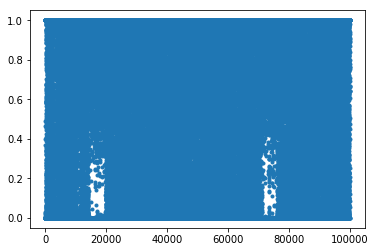

In [5]:
plt.plot([a for a in acceptance_probabilities], '.')

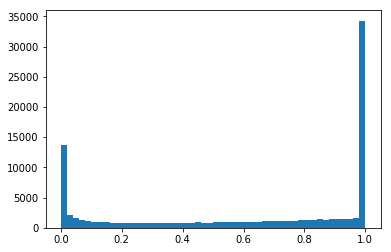

In [6]:
plt.hist(acceptance_probabilities, bins=50);

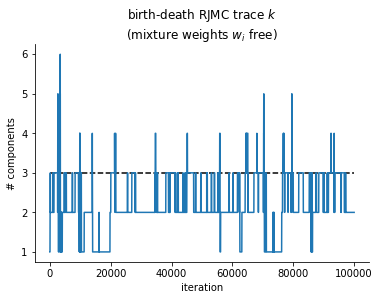

In [7]:
n_components_traj = [len(t[0]) / 3 for t in traj]
ax = plt.subplot(111)
plt.plot(n_components_traj)
plt.hlines(n_components, 0, len(traj), linestyles='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('# components')
plt.xlabel('iteration')
plt.title(r'birth-death RJMC trace $k$' + '\n(mixture weights ' + r'$w_i$ free)')
#plt.xscale('log')
plt.savefig('birth-death-n-components-starting-from-1.jpg', dpi=300)

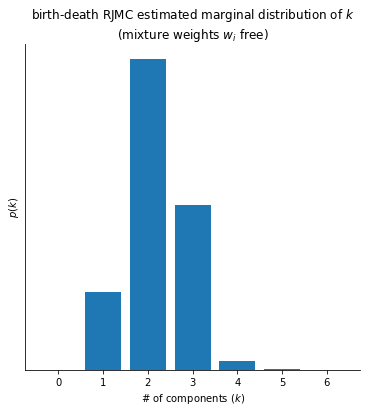

In [8]:
plt.figure(figsize=(6,6))

burned_in = n_components_traj[1000:]

counts = np.bincount(burned_in)
n_components_range = list(range(len(counts)))

ax = plt.subplot(111)

plt.bar(n_components_range, counts / sum(counts))
plt.xlabel(r'# of components ($k$)')
plt.ylabel(r'$p(k)$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r'birth-death RJMC estimated marginal distribution of $k$' + '\n(mixture weights ' + r'$w_i$ free)')
plt.xticks(n_components_range)
plt.yticks([])
plt.savefig('birth-death-marginals-starting-from-1.jpg', dpi=300)

In [9]:
change_points = list(np.arange(1, len(n_components_traj))[np.diff(n_components_traj) != 0])
trajs = []
for (start, end) in list(zip([0] + change_points, change_points + [len(traj)])):
    trajs.append(np.array([t[0] for t in traj[start:end]]))

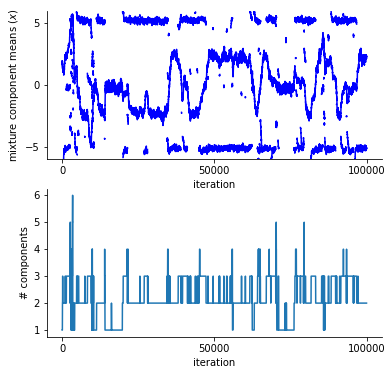

In [10]:
plt.figure(figsize=(6,6))
ax = plt.subplot(2, 1, 1)
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 3)
    plt.plot(np.arange(x_init, x_end), trajs[i][:,:n_components], color='blue')
plt.ylim(-6,6)
plt.yticks([-5,0,5])
plt.xticks([0,50000,100000])
plt.xlabel('iteration')
plt.ylabel(r'mixture component means ($x$)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax = plt.subplot(2, 1, 2, sharex=ax)
plt.plot(n_components_traj)
plt.xlabel('iteration')
plt.ylabel(r'# components')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('birth-death-branching-1.jpg', dpi=600, bbox_inches='tight')

In [11]:
np.random.seed(1)
init_n_components = 50
init_means = np.random.randn(init_n_components)
init_stdevs = np.random.rand(init_n_components) + 1
init_weights = np.random.rand(init_n_components)
init_weights /= np.sum(init_weights)
init_theta = np.hstack([init_means, init_stdevs, init_weights])
init_parents = [None] + list(range(init_n_components - 1))
traj, acceptance_probabilities = rjmcmc_w_parents(init_theta, init_parents, n_steps=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]/Users/joshuafass/anaconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
  0%|          | 27/100000 [00:00<12:37, 131.91it/s]

5: accepted a cross-model jump! # components: 50 --> 49
10: accepted a cross-model jump! # components: 49 --> 48
26: accepted a cross-model jump! # components: 48 --> 47


  0%|          | 68/100000 [00:00<12:50, 129.69it/s]

43: accepted a cross-model jump! # components: 47 --> 48
45: accepted a cross-model jump! # components: 48 --> 47
54: accepted a cross-model jump! # components: 47 --> 48
56: accepted a cross-model jump! # components: 48 --> 47


  0%|          | 97/100000 [00:00<12:23, 134.28it/s]

82: accepted a cross-model jump! # components: 47 --> 48


  0%|          | 144/100000 [00:01<11:38, 143.01it/s]

120: accepted a cross-model jump! # components: 48 --> 47


  0%|          | 210/100000 [00:01<11:17, 147.38it/s]

193: accepted a cross-model jump! # components: 47 --> 46
201: accepted a cross-model jump! # components: 46 --> 45
216: accepted a cross-model jump! # components: 45 --> 44


  0%|          | 308/100000 [00:02<10:17, 161.32it/s]

288: accepted a cross-model jump! # components: 44 --> 43
303: accepted a cross-model jump! # components: 43 --> 42


  0%|          | 343/100000 [00:02<10:16, 161.71it/s]

324: accepted a cross-model jump! # components: 42 --> 43
328: accepted a cross-model jump! # components: 43 --> 42


  0%|          | 452/100000 [00:02<09:21, 177.25it/s]

425: accepted a cross-model jump! # components: 42 --> 41
437: accepted a cross-model jump! # components: 41 --> 40
443: accepted a cross-model jump! # components: 40 --> 39


  1%|          | 528/100000 [00:03<09:00, 183.97it/s]

508: accepted a cross-model jump! # components: 39 --> 38
541: accepted a cross-model jump! # components: 38 --> 39


  1%|          | 603/100000 [00:03<09:29, 174.53it/s]

565: accepted a cross-model jump! # components: 39 --> 38


  1%|          | 660/100000 [00:04<09:08, 181.15it/s]

622: accepted a cross-model jump! # components: 38 --> 37


  1%|          | 698/100000 [00:04<09:01, 183.32it/s]

670: accepted a cross-model jump! # components: 37 --> 36


  1%|          | 735/100000 [00:04<10:20, 160.02it/s]

713: accepted a cross-model jump! # components: 36 --> 37


  1%|          | 807/100000 [00:05<10:59, 150.47it/s]

786: accepted a cross-model jump! # components: 37 --> 36
791: accepted a cross-model jump! # components: 36 --> 35
794: accepted a cross-model jump! # components: 35 --> 36


  1%|          | 956/100000 [00:05<08:50, 186.68it/s]

929: accepted a cross-model jump! # components: 36 --> 35
941: accepted a cross-model jump! # components: 35 --> 34


  1%|          | 1080/100000 [00:06<08:06, 203.40it/s]

1038: accepted a cross-model jump! # components: 34 --> 33


  1%|          | 1125/100000 [00:06<07:47, 211.35it/s]

1087: accepted a cross-model jump! # components: 33 --> 32
1102: accepted a cross-model jump! # components: 32 --> 31


  1%|          | 1192/100000 [00:07<07:43, 213.30it/s]

1169: accepted a cross-model jump! # components: 31 --> 30
1180: accepted a cross-model jump! # components: 30 --> 29
1189: accepted a cross-model jump! # components: 29 --> 28
1213: accepted a cross-model jump! # components: 28 --> 27
1214: accepted a cross-model jump! # components: 27 --> 26


  1%|▏         | 1299/100000 [00:07<06:33, 251.08it/s]

1263: accepted a cross-model jump! # components: 26 --> 25
1279: accepted a cross-model jump! # components: 25 --> 24
1294: accepted a cross-model jump! # components: 24 --> 23


  1%|▏         | 1390/100000 [00:07<05:52, 280.14it/s]

1335: accepted a cross-model jump! # components: 23 --> 22
1363: accepted a cross-model jump! # components: 22 --> 21
1373: accepted a cross-model jump! # components: 21 --> 20


  1%|▏         | 1457/100000 [00:07<05:24, 304.11it/s]

1403: accepted a cross-model jump! # components: 20 --> 19
1419: accepted a cross-model jump! # components: 19 --> 18
1423: accepted a cross-model jump! # components: 18 --> 17
1446: accepted a cross-model jump! # components: 17 --> 18
1469: accepted a cross-model jump! # components: 18 --> 17


  2%|▏         | 1525/100000 [00:08<05:07, 320.34it/s]

1484: accepted a cross-model jump! # components: 17 --> 18
1527: accepted a cross-model jump! # components: 18 --> 17


  2%|▏         | 1629/100000 [00:08<04:58, 329.87it/s]

1573: accepted a cross-model jump! # components: 17 --> 18
1600: accepted a cross-model jump! # components: 18 --> 17
1633: accepted a cross-model jump! # components: 17 --> 16


  2%|▏         | 1710/100000 [00:08<04:31, 361.74it/s]

1662: accepted a cross-model jump! # components: 16 --> 15
1693: accepted a cross-model jump! # components: 15 --> 16
1714: accepted a cross-model jump! # components: 16 --> 15
1719: accepted a cross-model jump! # components: 15 --> 14
1737: accepted a cross-model jump! # components: 14 --> 13


  2%|▏         | 1804/100000 [00:08<04:00, 408.24it/s]

1750: accepted a cross-model jump! # components: 13 --> 12
1825: accepted a cross-model jump! # components: 12 --> 11
1844: accepted a cross-model jump! # components: 11 --> 10
1846: accepted a cross-model jump! # components: 10 --> 11


  2%|▏         | 1959/100000 [00:09<03:26, 475.30it/s]

1895: accepted a cross-model jump! # components: 11 --> 10
1939: accepted a cross-model jump! # components: 10 --> 9
1974: accepted a cross-model jump! # components: 9 --> 10


  2%|▏         | 2111/100000 [00:09<03:20, 489.36it/s]

2038: accepted a cross-model jump! # components: 10 --> 11
2054: accepted a cross-model jump! # components: 11 --> 10
2064: accepted a cross-model jump! # components: 10 --> 9


  2%|▏         | 2237/100000 [00:09<02:57, 549.55it/s]

2160: accepted a cross-model jump! # components: 9 --> 8
2175: accepted a cross-model jump! # components: 8 --> 7
2187: accepted a cross-model jump! # components: 7 --> 6
2240: accepted a cross-model jump! # components: 6 --> 5
2285: accepted a cross-model jump! # components: 5 --> 6
2302: accepted a cross-model jump! # components: 6 --> 5


  3%|▎         | 2523/100000 [00:09<02:06, 767.94it/s]

2337: accepted a cross-model jump! # components: 5 --> 4
2350: accepted a cross-model jump! # components: 4 --> 3
2383: accepted a cross-model jump! # components: 3 --> 4
2433: accepted a cross-model jump! # components: 4 --> 3
2476: accepted a cross-model jump! # components: 3 --> 2
2488: accepted a cross-model jump! # components: 2 --> 3
2497: accepted a cross-model jump! # components: 3 --> 2
2514: accepted a cross-model jump! # components: 2 --> 1
2542: accepted a cross-model jump! # components: 1 --> 2


  3%|▎         | 2811/100000 [00:10<01:36, 1007.00it/s]

2559: accepted a cross-model jump! # components: 2 --> 1


  3%|▎         | 3220/100000 [00:10<01:20, 1197.44it/s]

3043: accepted a cross-model jump! # components: 1 --> 2


  4%|▎         | 3728/100000 [00:10<01:21, 1184.01it/s]

3594: accepted a cross-model jump! # components: 2 --> 3


  6%|▌         | 5547/100000 [00:12<01:34, 1003.83it/s]

5332: accepted a cross-model jump! # components: 3 --> 2
5342: accepted a cross-model jump! # components: 2 --> 3
5372: accepted a cross-model jump! # components: 3 --> 2
5504: accepted a cross-model jump! # components: 2 --> 3


  6%|▌         | 5875/100000 [00:12<01:28, 1058.32it/s]

5728: accepted a cross-model jump! # components: 3 --> 2
5768: accepted a cross-model jump! # components: 2 --> 3
5817: accepted a cross-model jump! # components: 3 --> 2
5872: accepted a cross-model jump! # components: 2 --> 3
5939: accepted a cross-model jump! # components: 3 --> 4


  6%|▌         | 6194/100000 [00:13<01:36, 970.65it/s] 

6027: accepted a cross-model jump! # components: 4 --> 5
6055: accepted a cross-model jump! # components: 5 --> 4
6144: accepted a cross-model jump! # components: 4 --> 3


  6%|▋         | 6423/100000 [00:13<01:29, 1051.43it/s]

6275: accepted a cross-model jump! # components: 3 --> 2
6339: accepted a cross-model jump! # components: 2 --> 3
6349: accepted a cross-model jump! # components: 3 --> 2


  7%|▋         | 6990/100000 [00:13<01:30, 1030.11it/s]

6822: accepted a cross-model jump! # components: 2 --> 3


  7%|▋         | 7302/100000 [00:14<01:32, 1000.38it/s]

7189: accepted a cross-model jump! # components: 3 --> 4
7254: accepted a cross-model jump! # components: 4 --> 3


  9%|▊         | 8647/100000 [00:15<01:17, 1176.37it/s]

8449: accepted a cross-model jump! # components: 3 --> 2


 10%|▉         | 9667/100000 [00:16<01:11, 1266.36it/s]

9507: accepted a cross-model jump! # components: 2 --> 3
9535: accepted a cross-model jump! # components: 3 --> 2


 12%|█▏        | 12455/100000 [00:18<01:10, 1239.12it/s]

12301: accepted a cross-model jump! # components: 2 --> 3
12311: accepted a cross-model jump! # components: 3 --> 2


 16%|█▌        | 15730/100000 [00:21<01:06, 1263.73it/s]

15511: accepted a cross-model jump! # components: 2 --> 3
15523: accepted a cross-model jump! # components: 3 --> 2


 16%|█▌        | 15979/100000 [00:21<01:15, 1119.64it/s]

15839: accepted a cross-model jump! # components: 2 --> 3


 17%|█▋        | 16719/100000 [00:22<01:06, 1247.89it/s]

16426: accepted a cross-model jump! # components: 3 --> 2
16428: accepted a cross-model jump! # components: 2 --> 3
16431: accepted a cross-model jump! # components: 3 --> 2
16444: accepted a cross-model jump! # components: 2 --> 1


 18%|█▊        | 17962/100000 [00:22<00:54, 1511.06it/s]

17802: accepted a cross-model jump! # components: 1 --> 2
17832: accepted a cross-model jump! # components: 2 --> 1


 19%|█▉        | 19234/100000 [00:23<00:51, 1580.45it/s]

18929: accepted a cross-model jump! # components: 1 --> 2
18935: accepted a cross-model jump! # components: 2 --> 1


 20%|██        | 20334/100000 [00:24<00:52, 1524.42it/s]

20121: accepted a cross-model jump! # components: 1 --> 2
20161: accepted a cross-model jump! # components: 2 --> 1


 21%|██        | 21105/100000 [00:24<00:54, 1442.25it/s]

21000: accepted a cross-model jump! # components: 1 --> 2
21023: accepted a cross-model jump! # components: 2 --> 1


 22%|██▏       | 22247/100000 [00:25<00:57, 1342.03it/s]

22016: accepted a cross-model jump! # components: 1 --> 2
22036: accepted a cross-model jump! # components: 2 --> 1
22092: accepted a cross-model jump! # components: 1 --> 2
22228: accepted a cross-model jump! # components: 2 --> 1


 23%|██▎       | 22681/100000 [00:26<00:55, 1405.03it/s]

22444: accepted a cross-model jump! # components: 1 --> 2
22476: accepted a cross-model jump! # components: 2 --> 1


 24%|██▍       | 24488/100000 [00:27<00:51, 1458.47it/s]

24187: accepted a cross-model jump! # components: 1 --> 2
24196: accepted a cross-model jump! # components: 2 --> 1


 27%|██▋       | 26993/100000 [00:29<00:48, 1507.59it/s]

26756: accepted a cross-model jump! # components: 1 --> 2
26792: accepted a cross-model jump! # components: 2 --> 1


 29%|██▉       | 29189/100000 [00:30<00:45, 1541.75it/s]

29025: accepted a cross-model jump! # components: 1 --> 2
29030: accepted a cross-model jump! # components: 2 --> 1


 33%|███▎      | 32757/100000 [00:32<00:48, 1393.63it/s]

32601: accepted a cross-model jump! # components: 1 --> 2


 33%|███▎      | 33162/100000 [00:33<00:53, 1260.75it/s]

32987: accepted a cross-model jump! # components: 2 --> 3
33091: accepted a cross-model jump! # components: 3 --> 2
33096: accepted a cross-model jump! # components: 2 --> 1


 33%|███▎      | 33430/100000 [00:33<00:53, 1254.13it/s]

33283: accepted a cross-model jump! # components: 1 --> 2


 34%|███▎      | 33687/100000 [00:33<00:54, 1227.87it/s]

33519: accepted a cross-model jump! # components: 2 --> 3
33522: accepted a cross-model jump! # components: 3 --> 2


 36%|███▌      | 35775/100000 [00:35<00:52, 1232.56it/s]

35646: accepted a cross-model jump! # components: 2 --> 3


 36%|███▌      | 36154/100000 [00:35<00:51, 1232.51it/s]

35902: accepted a cross-model jump! # components: 3 --> 2


 46%|████▌     | 45679/100000 [00:42<00:42, 1287.39it/s]

45531: accepted a cross-model jump! # components: 2 --> 3
45614: accepted a cross-model jump! # components: 3 --> 2
45702: accepted a cross-model jump! # components: 2 --> 3
45762: accepted a cross-model jump! # components: 3 --> 2


 48%|████▊     | 47774/100000 [00:44<00:42, 1228.46it/s]

47657: accepted a cross-model jump! # components: 2 --> 3


 49%|████▊     | 48724/100000 [00:45<00:43, 1178.62it/s]

48549: accepted a cross-model jump! # components: 3 --> 2
48567: accepted a cross-model jump! # components: 2 --> 3
48588: accepted a cross-model jump! # components: 3 --> 2
48704: accepted a cross-model jump! # components: 2 --> 1


 49%|████▉     | 48998/100000 [00:45<00:42, 1196.36it/s]

48855: accepted a cross-model jump! # components: 1 --> 2
48928: accepted a cross-model jump! # components: 2 --> 3
48940: accepted a cross-model jump! # components: 3 --> 4
49036: accepted a cross-model jump! # components: 4 --> 3
49066: accepted a cross-model jump! # components: 3 --> 2


 49%|████▉     | 49270/100000 [00:45<00:40, 1254.09it/s]

49098: accepted a cross-model jump! # components: 2 --> 1
49371: accepted a cross-model jump! # components: 1 --> 2


 50%|████▉     | 49729/100000 [00:46<00:35, 1428.45it/s]

49421: accepted a cross-model jump! # components: 2 --> 1


 56%|█████▌    | 55667/100000 [00:49<00:30, 1468.48it/s]

55472: accepted a cross-model jump! # components: 1 --> 2


 58%|█████▊    | 57565/100000 [00:51<00:35, 1206.43it/s]

57420: accepted a cross-model jump! # components: 2 --> 3
57469: accepted a cross-model jump! # components: 3 --> 4
57592: accepted a cross-model jump! # components: 4 --> 3


 58%|█████▊    | 57804/100000 [00:51<00:38, 1087.73it/s]

57660: accepted a cross-model jump! # components: 3 --> 4
57787: accepted a cross-model jump! # components: 4 --> 3
57788: accepted a cross-model jump! # components: 3 --> 2
57855: accepted a cross-model jump! # components: 2 --> 1


 58%|█████▊    | 58089/100000 [00:51<00:33, 1239.11it/s]

57889: accepted a cross-model jump! # components: 1 --> 2
57974: accepted a cross-model jump! # components: 2 --> 1


 61%|██████    | 60797/100000 [00:53<00:25, 1559.15it/s]

60583: accepted a cross-model jump! # components: 1 --> 2
60595: accepted a cross-model jump! # components: 2 --> 1
60842: accepted a cross-model jump! # components: 1 --> 2
60852: accepted a cross-model jump! # components: 2 --> 1


 63%|██████▎   | 62543/100000 [00:54<00:23, 1577.54it/s]

62323: accepted a cross-model jump! # components: 1 --> 2
62388: accepted a cross-model jump! # components: 2 --> 1


 64%|██████▍   | 63806/100000 [00:55<00:24, 1487.04it/s]

63696: accepted a cross-model jump! # components: 1 --> 2
63933: accepted a cross-model jump! # components: 2 --> 3


 64%|██████▍   | 64229/100000 [00:55<00:27, 1284.04it/s]

63990: accepted a cross-model jump! # components: 3 --> 2


 66%|██████▌   | 65628/100000 [00:57<00:28, 1221.64it/s]

65442: accepted a cross-model jump! # components: 2 --> 3
65456: accepted a cross-model jump! # components: 3 --> 2


 66%|██████▌   | 65866/100000 [00:57<00:32, 1055.74it/s]

65686: accepted a cross-model jump! # components: 2 --> 3
65737: accepted a cross-model jump! # components: 3 --> 2


 71%|███████   | 70711/100000 [01:01<00:24, 1200.44it/s]

70574: accepted a cross-model jump! # components: 2 --> 3


 72%|███████▏  | 71507/100000 [01:01<00:26, 1080.37it/s]

71394: accepted a cross-model jump! # components: 3 --> 2
71454: accepted a cross-model jump! # components: 2 --> 3


 72%|███████▏  | 71842/100000 [01:02<00:25, 1102.47it/s]

71676: accepted a cross-model jump! # components: 3 --> 2
71708: accepted a cross-model jump! # components: 2 --> 1
71714: accepted a cross-model jump! # components: 1 --> 2
71783: accepted a cross-model jump! # components: 2 --> 3
71874: accepted a cross-model jump! # components: 3 --> 2


 72%|███████▏  | 72071/100000 [01:02<00:24, 1120.72it/s]

71921: accepted a cross-model jump! # components: 2 --> 3
71930: accepted a cross-model jump! # components: 3 --> 2


 73%|███████▎  | 73457/100000 [01:03<00:22, 1180.89it/s]

73330: accepted a cross-model jump! # components: 2 --> 3


 74%|███████▍  | 74140/100000 [01:04<00:23, 1105.88it/s]

73990: accepted a cross-model jump! # components: 3 --> 2
74055: accepted a cross-model jump! # components: 2 --> 3
74067: accepted a cross-model jump! # components: 3 --> 2
74098: accepted a cross-model jump! # components: 2 --> 3
74192: accepted a cross-model jump! # components: 3 --> 2


 76%|███████▌  | 75742/100000 [01:05<00:20, 1192.48it/s]

75514: accepted a cross-model jump! # components: 2 --> 3
75670: accepted a cross-model jump! # components: 3 --> 2


 78%|███████▊  | 78247/100000 [01:07<00:18, 1164.08it/s]

78110: accepted a cross-model jump! # components: 2 --> 3


 79%|███████▊  | 78605/100000 [01:07<00:18, 1141.40it/s]

78373: accepted a cross-model jump! # components: 3 --> 2
78528: accepted a cross-model jump! # components: 2 --> 3


 79%|███████▊  | 78720/100000 [01:08<00:20, 1023.20it/s]

78614: accepted a cross-model jump! # components: 3 --> 4
78746: accepted a cross-model jump! # components: 4 --> 3


 80%|████████  | 80385/100000 [01:09<00:17, 1110.04it/s]

80169: accepted a cross-model jump! # components: 3 --> 2
80171: accepted a cross-model jump! # components: 2 --> 1
80198: accepted a cross-model jump! # components: 1 --> 2
80241: accepted a cross-model jump! # components: 2 --> 3
80306: accepted a cross-model jump! # components: 3 --> 2
80317: accepted a cross-model jump! # components: 2 --> 3
80359: accepted a cross-model jump! # components: 3 --> 2
80367: accepted a cross-model jump! # components: 2 --> 1


 81%|████████  | 80649/100000 [01:09<00:16, 1206.81it/s]

80477: accepted a cross-model jump! # components: 1 --> 2
80589: accepted a cross-model jump! # components: 2 --> 1


 81%|████████  | 81243/100000 [01:10<00:13, 1397.92it/s]

81016: accepted a cross-model jump! # components: 1 --> 2
81043: accepted a cross-model jump! # components: 2 --> 1


 83%|████████▎ | 82591/100000 [01:11<00:12, 1434.34it/s]

82443: accepted a cross-model jump! # components: 1 --> 2
82487: accepted a cross-model jump! # components: 2 --> 1
82502: accepted a cross-model jump! # components: 1 --> 2
82513: accepted a cross-model jump! # components: 2 --> 1


 83%|████████▎ | 83466/100000 [01:11<00:12, 1347.51it/s]

83269: accepted a cross-model jump! # components: 1 --> 2


 87%|████████▋ | 86865/100000 [01:14<00:11, 1095.39it/s]

86665: accepted a cross-model jump! # components: 2 --> 3
86692: accepted a cross-model jump! # components: 3 --> 4
86751: accepted a cross-model jump! # components: 4 --> 3


 88%|████████▊ | 87654/100000 [01:15<00:11, 1082.06it/s]

87463: accepted a cross-model jump! # components: 3 --> 2
87616: accepted a cross-model jump! # components: 2 --> 1
87676: accepted a cross-model jump! # components: 1 --> 2
87687: accepted a cross-model jump! # components: 2 --> 1


 88%|████████▊ | 87942/100000 [01:15<00:09, 1241.70it/s]

87751: accepted a cross-model jump! # components: 1 --> 2
87776: accepted a cross-model jump! # components: 2 --> 1


 89%|████████▊ | 88554/100000 [01:15<00:08, 1414.85it/s]

88303: accepted a cross-model jump! # components: 1 --> 2
88401: accepted a cross-model jump! # components: 2 --> 1


 89%|████████▉ | 88841/100000 [01:16<00:08, 1372.32it/s]

88640: accepted a cross-model jump! # components: 1 --> 2


 90%|█████████ | 90360/100000 [01:17<00:09, 970.70it/s] 

90215: accepted a cross-model jump! # components: 2 --> 3


 91%|█████████ | 90822/100000 [01:18<00:10, 842.44it/s]

90716: accepted a cross-model jump! # components: 3 --> 2
90727: accepted a cross-model jump! # components: 2 --> 3
90772: accepted a cross-model jump! # components: 3 --> 4
90775: accepted a cross-model jump! # components: 4 --> 3
90867: accepted a cross-model jump! # components: 3 --> 2
90876: accepted a cross-model jump! # components: 2 --> 3
90898: accepted a cross-model jump! # components: 3 --> 2


 91%|█████████ | 91121/100000 [01:18<00:09, 936.34it/s]

90923: accepted a cross-model jump! # components: 2 --> 3


 91%|█████████▏| 91364/100000 [01:18<00:08, 1062.30it/s]

91170: accepted a cross-model jump! # components: 3 --> 2
91228: accepted a cross-model jump! # components: 2 --> 1


 94%|█████████▎| 93580/100000 [01:20<00:05, 1108.18it/s]

93446: accepted a cross-model jump! # components: 1 --> 2
93485: accepted a cross-model jump! # components: 2 --> 1


 95%|█████████▍| 94562/100000 [01:20<00:04, 1326.28it/s]

94420: accepted a cross-model jump! # components: 1 --> 2


 95%|█████████▌| 95090/100000 [01:21<00:04, 1173.84it/s]

94983: accepted a cross-model jump! # components: 2 --> 3
95115: accepted a cross-model jump! # components: 3 --> 2


 96%|█████████▌| 95971/100000 [01:22<00:04, 964.57it/s] 

95852: accepted a cross-model jump! # components: 2 --> 3


 97%|█████████▋| 97274/100000 [01:23<00:02, 1133.13it/s]

97098: accepted a cross-model jump! # components: 3 --> 2


100%|██████████| 100000/100000 [01:25<00:00, 1166.98it/s]


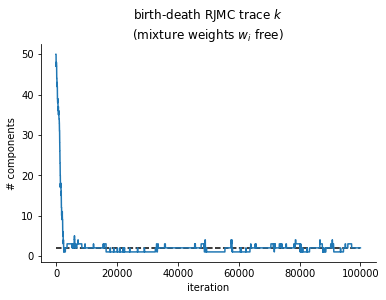

In [12]:
n_components_traj = [len(t[0]) / 3 for t in traj]
ax = plt.subplot(111)
plt.plot(n_components_traj)
plt.hlines(n_components, 0, len(traj), linestyles='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('# components')
plt.xlabel('iteration')
plt.title(r'birth-death RJMC trace $k$' + '\n(mixture weights ' + r'$w_i$ free)')
#plt.xscale('log')
plt.savefig('birth-death-n-components-starting-from-50.jpg', dpi=300)

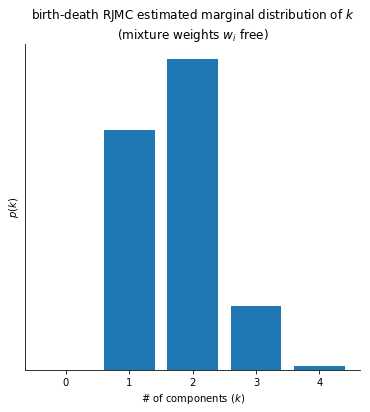

In [13]:
plt.figure(figsize=(6,6))

burned_in = n_components_traj[10000:]

counts = np.bincount(burned_in)
n_components_range = list(range(len(counts)))

ax = plt.subplot(111)

plt.bar(n_components_range, counts / sum(counts))
plt.xlabel(r'# of components ($k$)')
plt.ylabel(r'$p(k)$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r'birth-death RJMC estimated marginal distribution of $k$' + '\n(mixture weights ' + r'$w_i$ free)')
plt.xticks(n_components_range)
plt.yticks([])
plt.savefig('birth-death-marginals-starting-from-50.jpg', dpi=300)

In [14]:
change_points = list(np.arange(1, len(n_components_traj))[np.diff(n_components_traj) != 0])
trajs = []
for (start, end) in list(zip([0] + change_points, change_points + [len(traj)])):
    trajs.append(np.array([t[0] for t in traj[start:end]]))

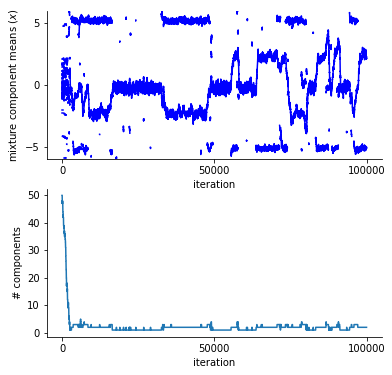

In [15]:
plt.figure(figsize=(6,6))
ax = plt.subplot(2, 1, 1)
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 3)
    plt.plot(np.arange(x_init, x_end), trajs[i][:,:n_components], color='blue')
plt.ylim(-6,6)
plt.yticks([-5,0,5])
plt.xticks([0,50000,100000])
plt.xlabel('iteration')
plt.ylabel(r'mixture component means ($x$)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax = plt.subplot(2, 1, 2, sharex=ax)
plt.plot(n_components_traj)
plt.xlabel('iteration')
plt.ylabel(r'# components')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('birth-death-branching-50.jpg', dpi=600, bbox_inches='tight')

In [16]:
trees = [t[-1] for t in traj[1000:]]

In [17]:
for _ in range(20):
    print(trees[np.random.randint(len(trees))])

[None, 0, 0]
[None]
[None, 0]
[None, 0]
[None, 0]
[None]
[None, 0]
[None]
[None]
[None]
[None, 0]
[None, 0, 1]
[None, 0]
[None]
[None, 0]
[None, 0]
[None]
[None, 0]
[None, 0, 0, 0]
[None]


In [18]:
import networkx as nx

In [19]:
def parent_list_to_graph(parent_list):
    
    graph = nx.DiGraph()
    
    for i in range(1, len(parent_list)):
        graph.add_edge(parent_list[i], i)
    return graph

In [20]:
g = parent_list_to_graph(trees[-1])
g.nodes()

NodeView((0, 1))

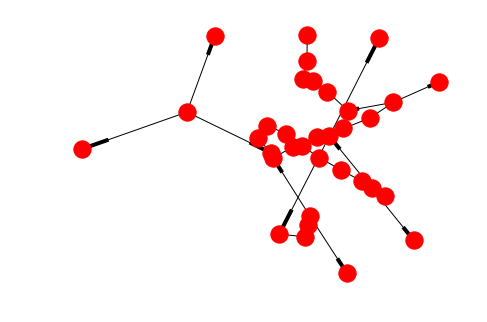

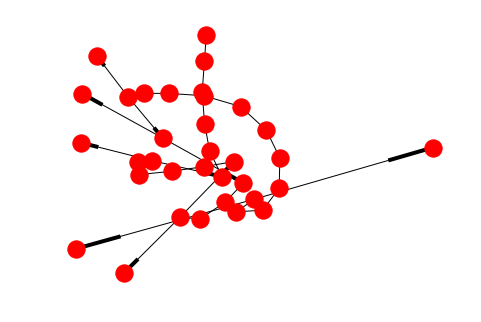

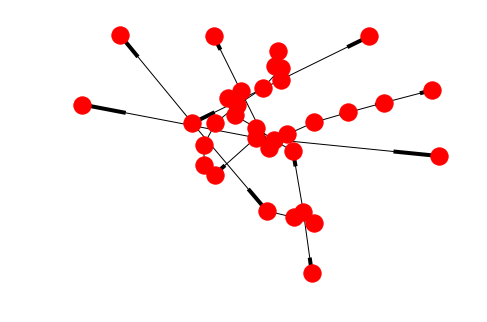

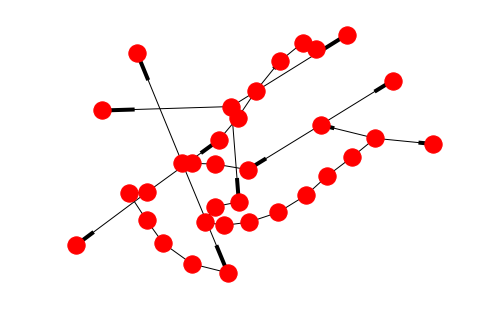

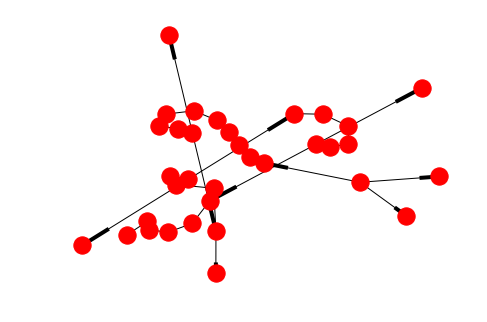

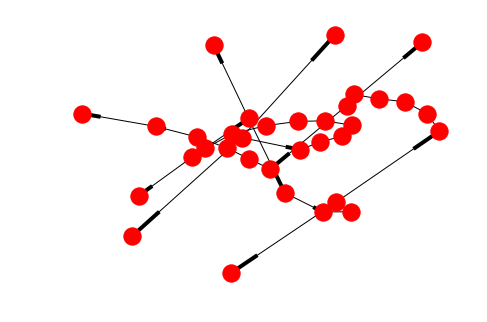

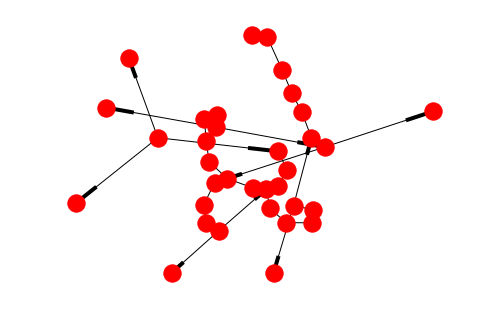

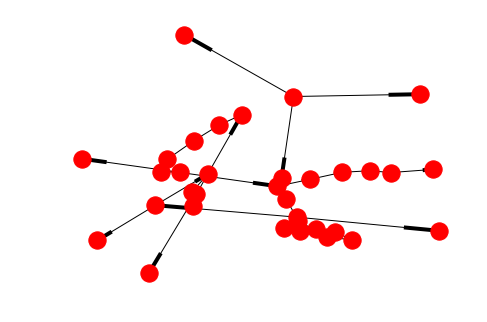

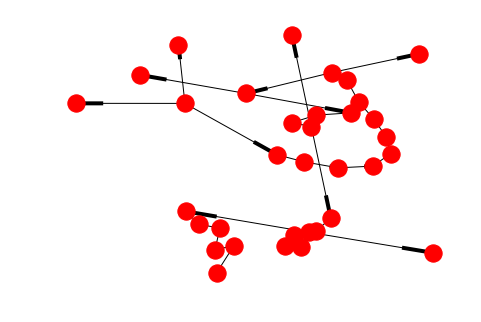

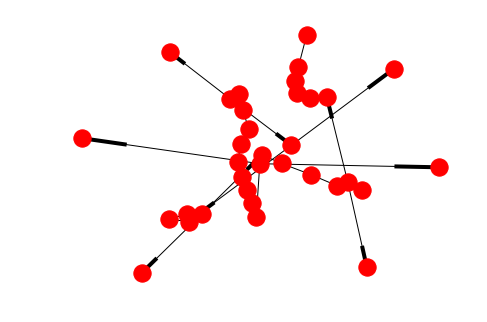

In [ ]:
for t in trees[:10]:
    g = parent_list_to_graph(t)
    plt.figure()
    nx.draw(g, pos=nx.drawing.spring_layout(g))

In [ ]:
log_posterior = np.array([flat_log_p(t[0]) for t in traj])
log_prior = np.array([log_prior(t[0]) for t in traj])
log_likelihood = log_posterior - log_prior

In [ ]:
plt.plot(log_prior, label='prior')
plt.plot(log_likelihood, label='likelihood')
plt.plot(log_posterior, label='posterior')
plt.legend(loc='best')
plt.ylabel('log probability')
plt.xlabel('iteration')
plt.xscale('log')

plt.savefig('birth-death-log-posterior.jpg', dpi=300)